In [1]:
# scikit-learn-intelex 
try:
    from sklearnex import patch_sklearn, unpatch_sklearn
    patch_sklearn()
except ModuleNotFoundError:
    pass

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


使用項目 = 気温, 日照時間, 月, 時間, 曜日, 訓練スコア = 0.960432, 検証スコア = 0.885535


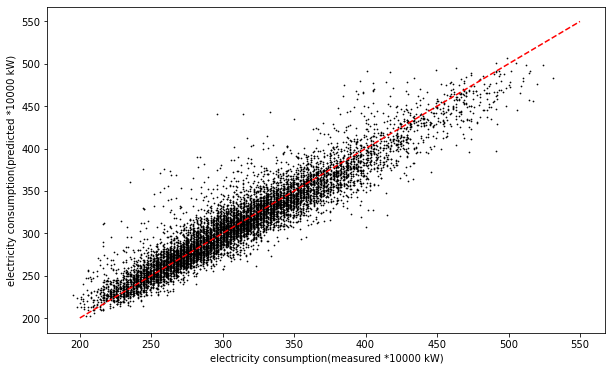

In [2]:
# coding: utf-8
import pandas as pd

# 四国電力の電力消費量データを読み込み
ed = [pd.read_csv(
    './data/juyo_shikoku_%d.csv' % year,
    skiprows=3,
    names=['DATE', 'TIME', 'consumption'],
    parse_dates={'date_hour': ['DATE', 'TIME']},
    index_col = "date_hour")
    for year in [2017, 2018, 2019, 2020, 2021]
]

elec_data = pd.concat(ed)# 連結し、すべての消費電力データを１つのDataFrameにまとめる

# 気象データを読み込み
tmp = pd.read_csv(
    u'./data/takamatsu.csv',
    skiprows=3,
    parse_dates={'date_hour': ["年月日時"]},
    index_col = "date_hour",
    na_values="×"
)

# del tmp["時"]  # 「時」の列は使わないので、削除
tmp.drop(index='NaT', inplace=True) # ２行目を削除

# 列の名前に日本語が入っているとよくないので、これから使う列の名前のみ英語に変更
columns = {
    "気温(℃)": "temperature",
    "日照時間(時間)": "sunhour",
    "日射量(MJ/㎡)": "solar_radiation",
    "相対湿度(％)": "humid",
}
tmp.rename(columns=columns, inplace=True)
tmp.fillna(-1,inplace=True)

# 月, 日, 時の取得
tmp["month"] = tmp.index.month
tmp['day'] = tmp.index.day
tmp['dayofyear'] = tmp.index.dayofyear
tmp['hour'] = tmp.index.hour
tmp['dayofweek'] = tmp.index.dayofweek


# 気象データと電力消費量データをいったん統合して時間軸を合わせたうえで、再度分割
#takamatsu = elec_data.join(tmp[["temperature","sunhour","month","hour"]]).dropna().as_matrix()
data_names = ["temperature","sunhour","month","hour","dayofweek"]
takamatsu = elec_data.join(tmp[data_names]).dropna().values

takamatsu_elec = takamatsu[:, 0:1]
takamatsu_wthr = takamatsu[:, 1:]

# 学習と性能の評価
#import sklearn.cross_validation
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor as RFR
model = RFR(verbose=False, n_jobs=-1)

#x_train, x_test, y_train, y_test = sklearn.cross_validation.train_test_split(
#    takamatsu_wthr, takamatsu_elec, test_size=0.2)
x_train, x_test, y_train, y_test = train_test_split(
    takamatsu_wthr, takamatsu_elec, test_size=0.2)

y_train = y_train.flatten()
y_test = y_test.flatten()

model.fit(x_train, y_train)
date_name = ["気温", "日照時間","月","時間", "曜日"]

output = "使用項目 = %s, 訓練スコア = %f, 検証スコア = %f" % \
         (", ".join(date_name),
          model.score(x_train, y_train),
          model.score(x_test, y_test)
          )
#    print (output.decode('utf-8')) # Python2の場合こちらの行を使ってください
print (output)  # Python3向け



# -- 可視化 --
import matplotlib.pyplot as plt
import matplotlib.style as mplstyle
mplstyle.use('fast')

# 画像のサイズを設定する
plt.figure(figsize=(10, 6))

predicted = model.predict(x_test)

plt.xlabel('electricity consumption(measured *10000 kW)')
plt.ylabel('electricity consumption(predicted *10000 kW)')
plt.scatter(y_test, predicted, s=0.5, color="black")
plt.plot([200, 550], [200, 550], 'r--')

#plt.savefig("7-5-5-4-graph.png")
plt.show()




### 特徴量重要度
scikit-learn の決定木分析では、分類に強い影響を与える特徴量かどうかを測る特徴量重要度という指標があります。特徴量重要度は、モデルのfeature_importances_で表示できます。

In [3]:
import pandas as pd
fti = pd.DataFrame(model.feature_importances_, index = data_names)
fti.columns=['特徴量重要度']
fti

,特徴量重要度
temperature,0.530805
sunhour,0.016515
month,0.040487
hour,0.270855
dayofweek,0.141338


訓練スコアと検証スコアに少し差が出る

ランダムフォレストの場合、標準化してもあまり効き目がない